# The Attention Mechanism - Interactive Learning Notebook

Welcome to the interactive attention mechanism tutorial! This notebook will guide you through implementing the core components of the attention mechanism step by step.

## Learning Objectives
By the end of this notebook, you will understand and implement:
1. **Linear Projections** for Query (Q), Key (K), and Value (V) matrices
2. **Scaled Dot-Product Attention** computation
3. **Softmax & Attention Weights** calculation
4. **Value Aggregation** using attention weights

## Example Prompt
Throughout this tutorial, we'll use this consistent example:

In [1]:
PROMPT_EXAMPLE = "The cat sat on the mat"
print(f"Working with example: '{PROMPT_EXAMPLE}'")

Working with example: 'The cat sat on the mat'


## 📍 Notebook Navigation

**Required (Graded):** Sections 1-4 + Final Evaluation
**Optional:** Everything after "END OF GRADED ASSIGNMENT" marker

⏱️ Estimated Time:
- Required sections: 45-60 minutes
- Optional exploration: 30+ minutes

## Setup and Imports
Let's start by importing the necessary libraries and setting up our environment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.visualizations import (
    visualize_qkv_projections,
    visualize_attention_scores,
    visualize_attention_weights,
    visualize_attended_values
)
from src.model_utils import tokenize_text, create_embeddings
from src.evaluation import evaluate_attention_output

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete! All libraries imported successfully.")

Visualization module loaded successfully!
Available functions:
- visualize_qkv_projections()
- visualize_attention_scores()
- visualize_attention_weights()
- visualize_attended_values()
- visualize_attention_flow()

Note: Epic 3 implementations now complete.
Model utilities module loaded successfully!
Available functions:
- tokenize_text()
- create_embeddings()
- positional_encoding()
- create_attention_mask()
- apply_attention_mask()
- load_pretrained_embeddings()
- save_model_checkpoint() / load_model_checkpoint()
- count_parameters() / get_model_size()
- validate_tensor_shapes()

Epic 5 - Transformer Integration Functions:
- load_mini_transformer() - Load and cache small transformer models
- compare_attention_implementations() - Compare reference vs production
- visualize_model_comparison() - Create educational visualizations
- adapt_dimensions() - Handle dimension mismatches (64D <-> 768D)

Note: Epic 5 functions require 'transformers' library for full functionality.
Epic 4 Evaluat

---
# 📝 REQUIRED: Section 1: Linear Projections (Q, K, V)

## The Intuition: Three Perspectives on Information

Imagine you're at a library looking for information about "machine learning books." You would:
1. **Ask** the librarian about books on machine learning (Query - what you're looking for)
2. The librarian **checks** the catalog for available books (Keys - what's available to match)
3. You **receive** the actual books that match (Values - the information you get)

In attention mechanisms, we create these three "perspectives" for each word in our sentence.

## Theory: Why Do We Need Q, K, V?

The attention mechanism needs to answer: **"For each word, which other words should it pay attention to?"**

Consider our example: **"The cat sat on the mat"**

For the word "cat":
- **Query (Q)**: "What information does 'cat' need?" → Maybe it needs to know what action it's performing
- **Key (K)**: "What information can each word provide?" → "sat" can provide action information  
- **Value (V)**: "What is the actual information?" → The semantic meaning of "sat" (an action)

### The Three Transformations

Starting with the same input embeddings **X**, we create three different "views":

- **Query (Q)**: *"What am I looking for?"* - Transforms input to represent information needs
- **Key (K)**: *"What can I provide?"* - Transforms input to represent available information  
- **Value (V)**: *"What information do I actually contain?"* - Transforms input to represent the content to be retrieved

### Mathematical Formulation

$$Q = XW_Q$$
$$K = XW_K$$  
$$V = XW_V$$

Where:
- $X \in \mathbb{R}^{L \times d_{model}}$: Input embeddings (sequence length × embedding dimension)
- $W_Q, W_K, W_V \in \mathbb{R}^{d_{model} \times d_k}$: Learned weight matrices (embedding dim × projection dim)
- $Q, K, V \in \mathbb{R}^{L \times d_k}$: Projected query, key, value matrices

### Why Different Weight Matrices?

Each weight matrix learns to extract different aspects:
- $W_Q$: Learns to extract "what information this position needs"
- $W_K$: Learns to extract "what information this position can provide" 
- $W_V$: Learns to extract "the actual information content"

### Tensor Shape Deep Dive

For "The cat sat on the mat" (6 tokens):
- Input embeddings: `(1, 6, 512)` → 1 batch, 6 tokens, 512-dim embeddings
- After projection: `(1, 6, 64)` → 1 batch, 6 tokens, 64-dim projections

The reduction from 512 to 64 dimensions serves two purposes:
1. **Computational efficiency**: Smaller attention computations
2. **Multiple heads**: We can have multiple attention heads in parallel

# PART A: CORE ASSIGNMENT (GRADED)

In [3]:
# Initialize example data
PROMPT_EXAMPLE = "The cat sat on the mat"
tokens = tokenize_text(PROMPT_EXAMPLE)
embeddings = create_embeddings(tokens)
print(f"Tokens: {tokens}")
print(f"Embedding shape: {embeddings.shape}")

Tokens: ['<BOS>', 'the', 'cat', 'sat', 'on', 'the', 'mat', '<EOS>']
Embedding shape: torch.Size([1, 8, 512])


In [ ]:
def create_qkv_projections(embeddings, d_model=512, d_k=64):
    """
    Create Query, Key, and Value projections from input embeddings.
    
    Args:
        embeddings: Input embeddings tensor (batch_size, seq_len, d_model)
        d_model: Dimension of input embeddings
        d_k: Dimension of Q, K, V projections
    
    Returns:
        Q, K, V: Query, Key, Value tensors (batch_size, seq_len, d_k)
    """
    
    # ===== REQUIRED IMPLEMENTATION (GRADED) =====
    # TODO: Get input dimensions
    batch_size, seq_len, embedding_dim = embeddings.shape

    # TODO: Create linear projection layers
    W_Q = nn.Linear(d_model, d_k, bias=False)
    W_K = nn.Linear(d_model, d_k, bias=False)
    W_V = nn.Linear(d_model, d_k, bias=False)

    # TODO: Apply projections to input embedings
    Q = W_Q(embeddings)
    K = W_K(embeddings)
    V = W_V(embeddings)
    
    # ===== END REQUIRED SECTION =====
    
    return Q, K, V

# Test implementation
Q, K, V = create_qkv_projections(embeddings)
print(f"Q shape: {Q.shape}, K shape: {K.shape}, V shape: {V.shape}")
print("Successfully created Q, K, V projections!")

In [ ]:
# VISUALIZATION
visualize_qkv_projections(Q, K, V, tokens)

---
# 📝 REQUIRED: Section 2: Scaled Dot-Product Attention

## The Intuition: Measuring Compatibility

Think of this step as **matchmaking between questions and answers**:
- Each Query asks: *"What information do I need?"*
- Each Key responds: *"Here's what I can provide"*  
- The dot product measures: *"How well do they match?"*

### Why Dot Product for Similarity?

The dot product between two vectors measures their **alignment**:
- **High dot product**: Vectors point in similar directions → High compatibility
- **Low dot product**: Vectors are orthogonal → Low compatibility  
- **Negative dot product**: Vectors point in opposite directions → Incompatible

**Example**: If Query for "cat" is looking for "action information" and Key for "sat" provides "action information", their dot product will be high.

### The Mathematical Operation

$$\text{Attention Scores} = \frac{QK^T}{\sqrt{d_k}}$$

Let's break this down step by step:

#### Step 1: Matrix Multiplication $QK^T$
- $Q \in \mathbb{R}^{L \times d_k}$: Each row is a query vector for one token
- $K^T \in \mathbb{R}^{d_k \times L}$: Each column is a key vector for one token  
- Result: $\mathbb{R}^{L \times L}$ matrix where entry $(i,j)$ = similarity between token $i$'s query and token $j$'s key

#### Step 2: Scaling by $\sqrt{d_k}$

**Why do we need scaling?**
As the dimension $d_k$ increases, dot products tend to grow larger in magnitude. This pushes values toward the extremes of the softmax function where gradients become extremely small.

**The Problem**: Without scaling, for $d_k = 512$:
- Random dot products have variance ≈ 512
- Softmax becomes nearly deterministic (almost one-hot)
- Gradients vanish during training

**The Solution**: Dividing by $\sqrt{d_k}$ normalizes the variance back to ≈ 1

### Tensor Shape Analysis

For "The cat sat on the mat" (6 tokens, $d_k = 64$):

1. **Q shape**: `(1, 6, 64)` - 6 query vectors, each 64-dimensional
2. **K shape**: `(1, 6, 64)` - 6 key vectors, each 64-dimensional  
3. **K^T shape**: `(1, 64, 6)` - Transposed for matrix multiplication
4. **QK^T shape**: `(1, 6, 6)` - 6×6 attention score matrix

Each element `[i, j]` represents: *"How much should token i attend to token j?"*

### Attention Score Matrix Interpretation

For our example sentence, the 6×6 matrix might look like:
```
         The  cat  sat  on  the  mat
    The  [ ?   ?    ?   ?   ?    ? ]
    cat  [ ?   ?    ?   ?   ?    ? ]  
    sat  [ ?   ?    ?   ?   ?    ? ]
    on   [ ?   ?    ?   ?   ?    ? ]
    the  [ ?   ?    ?   ?   ?    ? ]
    mat  [ ?   ?    ?   ?   ?    ? ]
```

Higher scores indicate stronger relationships (e.g., "cat" → "sat" for subject-verb relationship).

### The Complete Formula Intuition

$$\text{Score}_{i,j} = \frac{\text{query}_i \cdot \text{key}_j}{\sqrt{d_k}}$$

This answers: *"How relevant is the information that token j can provide to what token i is looking for?"*

In [ ]:
def compute_attention_scores(Q, K):
    """
    Compute scaled dot-product attention scores.
    
    Args:
        Q: Query tensor (batch_size, seq_len, d_k)
        K: Key tensor (batch_size, seq_len, d_k)
    
    Returns:
        attention_scores: Attention scores (batch_size, seq_len, seq_len)
    """
    # Implementation follows: scores = Q * K^T / sqrt(d_k)
    
    # ===== REQUIRED IMPLEMENTATION (GRADED) =====
    # TODO: Get the dimension d_k for scaling
    d_k = Q.shape[-1]
    
    # TODO: Compute dot product between Q and K^T
    # Q: (batch_size, seq_len, d_k)
    # K^T: (batch_size, d_k, seq_len)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    
    # TODO: Scale by sqrt(d_k) to prevent extreme values
    attention_scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    
    # ===== END REQUIRED SECTION =====
    
    return attention_scores

# Test implementation
attention_scores = compute_attention_scores(Q, K)
print(f"Attention scores shape: {attention_scores.shape}")
print(f"d_k = {Q.shape[-1]}, scaling factor = {torch.sqrt(torch.tensor(Q.shape[-1], dtype=torch.float32)):.2f}")
print("Successfully computed attention scores!")

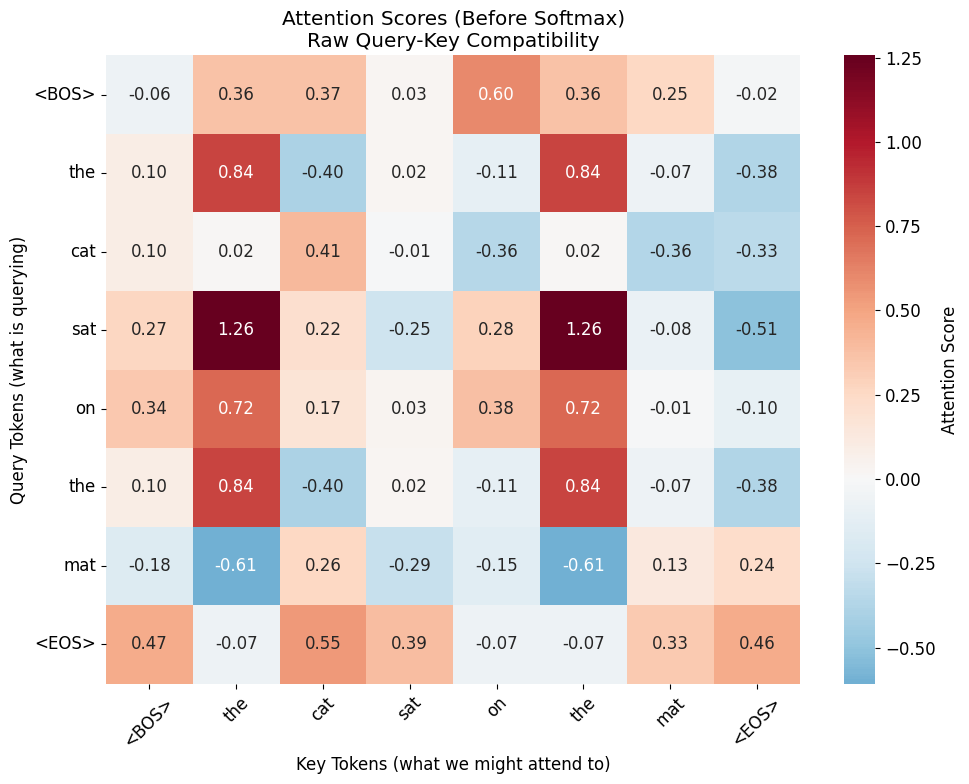

Attention Scores Visualization
This shows raw compatibility scores between queries and keys:
- Higher values (red): Strong compatibility between query and key
- Lower values (blue): Weak compatibility
- Values are scaled by 1/sqrt(d_k) for numerical stability
- These will be normalized with softmax to create attention weights


In [6]:
# VISUALIZATION
visualize_attention_scores(attention_scores, tokens)

---
# 📝 REQUIRED: Section 3: Softmax & Attention Weights

## The Intuition: From Scores to Decisions

Imagine you're deciding how to allocate your attention while reading "The cat sat on the mat":
- You have **compatibility scores** for how relevant each word is
- But you need to make a **decision**: How much attention to give each word?
- Softmax converts raw scores into a **probability distribution** - a recipe for attention allocation

### Why Convert to Probabilities?

Raw attention scores can be any real numbers (positive, negative, large, small). We need:
1. **Interpretability**: Weights between 0 and 1 are easier to understand
2. **Normalization**: Weights sum to 1, so we're not "over-attending"  
3. **Differentiability**: Smooth function for gradient-based learning

### The Softmax Function

$$\text{Attention Weight}_{i,j} = \frac{\exp(\text{Score}_{i,j})}{\sum_{k=1}^{L} \exp(\text{Score}_{i,k})}$$

**What this does**:
- **Exponential**: $\exp(x)$ makes all values positive and amplifies differences
- **Normalization**: Division ensures weights sum to 1 for each query position
- **Probability distribution**: Each row becomes a valid probability distribution

### Step-by-Step Example

For "The cat sat on the mat", let's say token "cat" has attention scores:
```
Raw scores:     [0.1, 0.8, 1.2, 0.3, 0.1, 0.4]
After exp():    [1.11, 2.23, 3.32, 1.35, 1.11, 1.49]
Sum:            11.61
After softmax:  [0.09, 0.19, 0.29, 0.12, 0.09, 0.13]
```

**Interpretation**: "cat" should pay:
- 29% attention to "sat" (highest score → highest weight)
- 19% attention to itself  
- 13% attention to "mat"
- etc.

### The Attention Matrix

After applying softmax to all rows, we get a **stochastic matrix**:

$$\text{Attention}_{6 \times 6} = \begin{bmatrix}
\text{The→The} & \text{The→cat} & \text{The→sat} & \cdots \\
\text{cat→The} & \text{cat→cat} & \text{cat→sat} & \cdots \\
\text{sat→The} & \text{sat→cat} & \text{sat→sat} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}$$

**Properties**:
- Each row sums to 1 (probability distribution)
- Each entry is between 0 and 1
- Row $i$ shows how token $i$ distributes its attention

### Concrete Example: "The cat sat on the mat"

The attention weights might reveal linguistic patterns:
```
         The   cat   sat   on    the   mat
    The [0.2, 0.15, 0.1, 0.15, 0.25, 0.15]  # Articles attend to nouns
    cat [0.1, 0.25, 0.4, 0.05, 0.05, 0.15]  # Subject attends to verb
    sat [0.05, 0.35, 0.3, 0.1, 0.05, 0.15]  # Verb attends to subject
    on  [0.1, 0.1, 0.15, 0.2, 0.15, 0.3]   # Preposition attends to object
    the [0.15, 0.1, 0.1, 0.15, 0.25, 0.25]  # Article attends to noun
    mat [0.1, 0.2, 0.15, 0.25, 0.15, 0.15]  # Object attends to preposition
```

**Key Insights**:
- "cat" (row 2) has highest weight 0.4 for "sat" → Subject-verb relationship
- "on" (row 4) has highest weight 0.3 for "mat" → Preposition-object relationship
- Self-attention captures word importance in context

### Mathematical Properties

1. **Row-wise normalization**: $\sum_{j=1}^{L} \text{Attention}_{i,j} = 1$ for all $i$

2. **Temperature effect**: Higher scores get exponentially more weight
   - Score difference of 1 → Weight ratio of $e ≈ 2.7$
   - Score difference of 2 → Weight ratio of $e^2 ≈ 7.4$

3. **Concentration**: Softmax concentrates probability mass on highest scores

In [ ]:
# COMPLETED: Implement softmax to get attention weights
# Implemented: Apply softmax to convert attention scores to attention weights

def compute_attention_weights(attention_scores):
    """
    Convert attention scores to attention weights using softmax.
    
    Args:
        attention_scores: Attention scores (batch_size, seq_len, seq_len)
    
    Returns:
        attention_weights: Attention weights (batch_size, seq_len, seq_len)
    """
    # Implementation follows: weights = softmax(scores)
    
    # ===== REQUIRED IMPLEMENTATION (GRADED) =====
    # TODO: Apply softmax along the last dimension (key positions)
    attention_weights = F.softmax(attention_scores, dim=-1)

    # ===== END REQUIRED SECTION =====
    
    return attention_weights

# Test implementation
attention_weights = compute_attention_weights(attention_scores)
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Sum of weights for first query position: {attention_weights[0, 0, :].sum():.4f}")
print(f"Sum of weights for second query position: {attention_weights[0, 1, :].sum():.4f}")
print("All attention weights should sum to 1.0 for each query position")
print("Successfully computed attention weights!")

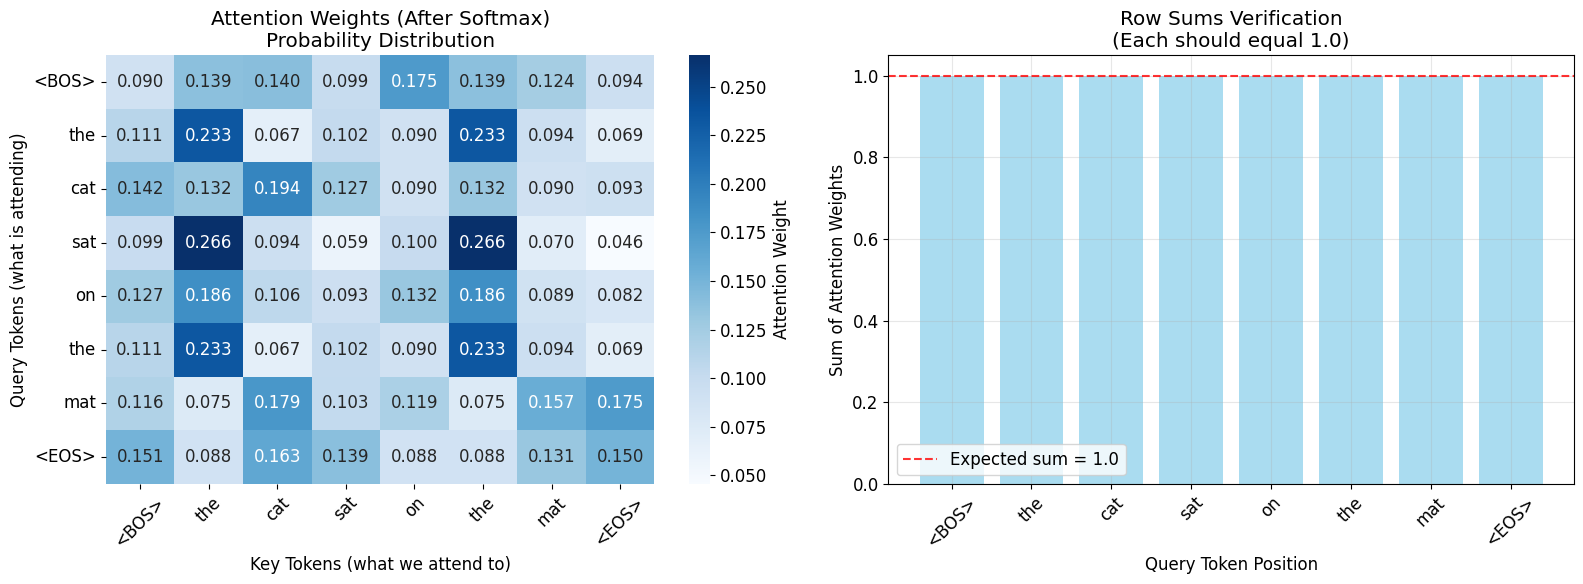

Attention Weights Visualization
This shows normalized attention weights (probabilities):
- Each row sums to 1.0 (verified in right plot)
- Darker blue = higher attention weight
- Shows which tokens each query position attends to most
- These weights will be used to aggregate value vectors


In [8]:
# VISUALIZATION
visualize_attention_weights(attention_weights, tokens)

---
# 📝 REQUIRED: Section 4: Value Aggregation

## The Intuition: Gathering Information

Now comes the payoff! We've decided **where** to look (attention weights), now we need to **gather** the actual information from those locations. This is like:

- **Step 3 of our library analogy**: After deciding which books are most relevant (attention weights), you actually **read and combine** information from those books (values)
- **Weighted averaging**: Instead of reading all books equally, you focus more on the most relevant ones

### The Mathematical Operation

$$\text{Output} = \text{Attention Weights} \times V$$

More precisely:
$$\text{Output}_i = \sum_{j=1}^{L} \text{Attention}_{i,j} \times V_j$$

Where:
- $\text{Output}_i$: The new representation for token $i$
- $\text{Attention}_{i,j}$: How much token $i$ attends to token $j$  
- $V_j$: The value vector for token $j$

### Conceptual Understanding

For each token, we create a **personalized summary** of the entire sequence:

**For token "cat" in "The cat sat on the mat":**
```
Original value of "cat": [cat's semantic features]
After attention:         [0.1×"The" + 0.25×"cat" + 0.4×"sat" + 0.05×"on" + 0.05×"the" + 0.15×"mat"]
```

**The result**: "cat" now contains:
- 40% of "sat"'s information (strong subject-verb connection)  
- 25% of its own information (self-context)
- 15% of "mat"'s information (object relationship)
- Small amounts from other tokens

### What Makes This Powerful?

1. **Contextualization**: Each token's representation now includes relevant context
2. **Selective Focus**: More important relationships get more weight
3. **Information Flow**: Semantic information flows from keys to queries through values

### Tensor Shape Analysis

For "The cat sat on the mat" (6 tokens, $d_k = 64$):

1. **Attention weights**: `(1, 6, 6)` - How each token attends to every other token
2. **Values (V)**: `(1, 6, 64)` - 64-dimensional value vector for each token
3. **Output**: `(1, 6, 64)` - 64-dimensional attended representation for each token

**Matrix multiplication**:
- Row $i$ of attention weights: `(1, 6)` - attention distribution for token $i$
- Full values matrix: `(6, 64)` - all value vectors
- Result for token $i$: `(1, 64)` - weighted combination of all value vectors

### The Complete Information Flow

Let's trace what happens to the word "cat":

1. **Query Creation**: "cat" → Query vector (what information does "cat" need?)
2. **Attention Computation**: Query compared to all Key vectors → Attention scores  
3. **Softmax**: Attention scores → Attention weights (probability distribution)
4. **Value Aggregation**: Attention weights × Value vectors → Final representation

**The result**: The new representation of "cat" contains:
- Its original semantic information
- **Plus** contextual information from "sat" (it performs this action)
- **Plus** contextual information from "mat" (location relationship)  
- **Plus** smaller amounts from other tokens

### Why Values Are Different From Keys?

- **Keys**: Optimized to be "found" by queries (searchable representations)
- **Values**: Optimized to provide useful information (retrievable content)
- **Analogy**: Keys are like book titles/tags, Values are like book contents

### Example: Attention in Practice

For "The cat sat on the mat":

**Before attention**: Each word has only its own meaning
- "cat" → [animal, feline, small, ...]
- "sat" → [action, past tense, positioning, ...]

**After attention**: Each word incorporates contextual information  
- "cat" → [animal, feline, **performed sitting**, **on furniture**, ...]
- "sat" → [action, **done by cat**, past tense, **on mat**, ...]

### The Output: Contextualized Representations

The final output is a set of **contextualized embeddings** where each token's representation has been enriched with relevant information from the entire sequence, weighted by attention.

This forms the foundation for:
- **Language understanding**: Words understand their context
- **Compositionality**: Meaning emerges from relationships  
- **Long-range dependencies**: Distant words can influence each other

In [ ]:
def aggregate_values(attention_weights, V):
    """
    Aggregate value vectors using attention weights.
    
    Args:
        attention_weights: Attention weights (batch_size, seq_len, seq_len)
        V: Value tensor (batch_size, seq_len, d_v)
    
    Returns:
        output: Attended output (batch_size, seq_len, d_v)
    """
    # ===== REQUIRED IMPLEMENTATION (GRADED) =====
    # TODO: Multiply attention weights with value vectors
    # attention_weights: (batch_size, seq_len, seq_len)
    # V: (batch_size, seq_len, d_v)
    # output: (batch_size, seq_len, d_v)
    output = torch.matmul(attention_weights, V)
    
    # ===== END REQUIRED SECTION =====
    
    return output

# Test implementation
attended_output = aggregate_values(attention_weights, V)
print(f"Attended output shape: {attended_output.shape}")
print(f"Original V shape: {V.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print("Successfully computed attended values!")
print("Each token now has a contextualized representation!")

In [ ]:
# VISUALIZATION
visualize_attended_values(attended_output, attention_weights, tokens)

---
# Complete Attention Mechanism

You did it, great job!
Now let's put it all together into a complete attention function

In [12]:
def attention_mechanism(embeddings, d_k=64):
    """
    Complete attention mechanism implementation.
    
    Args:
        embeddings: Input embeddings (batch_size, seq_len, d_model)
        d_k: Dimension for Q, K, V projections
    
    Returns:
        output: Attended output (batch_size, seq_len, d_k)
        attention_weights: Attention weights for visualization
    """
    # Create Q, K, V projections
    Q, K, V = create_qkv_projections(embeddings, d_k=d_k)
    
    # Compute attention scores
    attention_scores = compute_attention_scores(Q, K)
    
    # Apply softmax to get attention weights
    attention_weights = compute_attention_weights(attention_scores)
    
    # Aggregate values using attention weights
    output = aggregate_values(attention_weights, V)
    
    return output, attention_weights

# Test complete implementation
final_output, final_attention_weights = attention_mechanism(embeddings)
print(f"Final output shape: {final_output.shape}")
print(f"Final attention weights shape: {final_attention_weights.shape}")
print(f"Input embedding dim: {embeddings.shape[-1]}, Output dim: {final_output.shape[-1]}")
print("Complete attention mechanism implemented successfully!")
print("The attention mechanism has transformed static embeddings into contextualized representations!")

Final output shape: torch.Size([1, 8, 64])
Final attention weights shape: torch.Size([1, 8, 8])
Input embedding dim: 512, Output dim: 64
Complete attention mechanism implemented successfully!
The attention mechanism has transformed static embeddings into contextualized representations!


In [13]:
# Evaluation of your implementation
evaluation_results = evaluate_attention_output(final_output, final_attention_weights, embeddings)
print("Evaluation Results:")
for key, value in evaluation_results.items():
    print(f"{key}: {value}")

Evaluation Results:
timestamp: 1759149745.2501822
status: completed
overall_score: 100.0
checks: {'shape_validation': {'passed': True, 'expected_output_shape': (1, 8, 'd_v'), 'actual_output_shape': torch.Size([1, 8, 64]), 'expected_weights_shape': (1, 8, 8), 'actual_weights_shape': torch.Size([1, 8, 8])}, 'attention_weights_normalization': {'passed': True, 'description': 'Attention weights should sum to 1 for each query', 'sample_sums': [1.0, 1.0, 1.0]}, 'finite_values': {'passed': tensor(True), 'output_finite': True, 'weights_finite': True}}
feedback: ['✅ Output shapes are correct', '✅ Attention weights properly normalized', '✅ No NaN or infinite values detected']
metrics: {'output_mean': 0.0015581082552671432, 'output_std': 0.23500679433345795, 'weights_entropy': 2.037080764770508, 'max_attention_weight': 0.21755212545394897, 'min_attention_weight': 0.05727791786193848}


c:\Users\felix\Desktop\Code\Skola\AI2\vg-assignment\the-attention-mechanism\src\evaluation.py:126: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  'output_mean': float(torch.mean(output)),


# ═══════════════════════════════════════════════════════════════
# END OF GRADED ASSIGNMENT
# ═══════════════════════════════════════════════════════════════

# OPTIONAL EXPLORATION BELOW
# The following sections are for deeper understanding but NOT required

# PART B: DEEPER UNDERSTANDING (OPTIONAL)

In [ ]:
def attention_mechanism(embeddings, d_k=64):
    """
    Complete attention mechanism implementation.
    
    Args:
        embeddings: Input embeddings (batch_size, seq_len, d_model)
        d_k: Dimension for Q, K, V projections
    
    Returns:
        output: Attended output (batch_size, seq_len, d_k)
        attention_weights: Attention weights for visualization
    """
    # Create Q, K, V projections
    Q, K, V = create_qkv_projections(embeddings, d_k=d_k)
    
    # Compute attention scores
    attention_scores = compute_attention_scores(Q, K)
    
    # Apply softmax to get attention weights
    attention_weights = compute_attention_weights(attention_scores)
    
    # Aggregate values using attention weights
    output = aggregate_values(attention_weights, V)
    
    return output, attention_weights

# Test complete implementation
final_output, final_attention_weights = attention_mechanism(embeddings)
print(f"Final output shape: {final_output.shape}")
print(f"Final attention weights shape: {final_attention_weights.shape}")
print(f"Input embedding dim: {embeddings.shape[-1]}, Output dim: {final_output.shape[-1]}")
print("Complete attention mechanism implemented successfully!")
print("The attention mechanism has transformed static embeddings into contextualized representations!")

## 🔬 OPTIONAL: The Big Picture: How Attention Transforms Understanding

You have successfully implemented the attention mechanism! Let's connect all the pieces to see the complete picture.

### The Four-Step Journey

**The attention mechanism solves a fundamental problem**: How can each word in a sentence understand and incorporate information from all other words?

1. **Linear Projections (Q, K, V)**: Create three different "views" of each word
   - Transform static embeddings into dynamic, task-specific representations
   - Enable words to express what they need, what they offer, and what they contain

2. **Scaled Dot-Product**: Measure compatibility between information needs and offerings
   - Quantify relationships through geometric similarity (dot products)
   - Scale to maintain stable gradients for effective learning

3. **Softmax Normalization**: Convert compatibility into attention allocation  
   - Create probability distributions for interpretable attention weights
   - Ensure each word allocates exactly 100% of its attention across all positions

4. **Value Aggregation**: Gather and combine relevant information
   - Perform weighted averaging based on attention decisions
   - Create contextualized representations that incorporate global information

### The Transformation: From Static to Dynamic

**Before Attention** (Static embeddings):
```
"The" → [article, definite, ...]
"cat" → [animal, feline, small, ...]  
"sat" → [action, past, positioning, ...]
"on"  → [preposition, spatial, ...]
"the" → [article, definite, ...]
"mat" → [object, flat, surface, ...]
```

**After Attention** (Contextualized representations):
```
"The" → [article, **refers to cat**, definite, ...]
"cat" → [animal, **performs sitting**, feline, **subject role**, ...]
"sat" → [action, **done by cat**, past, **on surface**, ...]  
"on"  → [preposition, **connects cat and mat**, spatial, ...]
"the" → [article, **refers to mat**, definite, ...]
"mat" → [object, **location of sitting**, flat, **receives cat**, ...]
```

### Key Insights and Implications

#### 1. **Parallel Processing**
Unlike sequential models (RNNs), attention processes all positions simultaneously:
- All words can attend to all other words in one pass
- Enables parallelization and faster training
- Captures long-range dependencies directly

#### 2. **Learned Relationships**  
The attention patterns emerge from learning, not hard-coded rules:
- Q, K, V projections learn what relationships to look for
- Attention weights discover syntactic and semantic patterns
- Model learns grammar, syntax, and semantics implicitly

#### 3. **Context-Dependent Meaning**
Words develop different meanings based on context:
- "bank" in "river bank" vs. "savings bank" gets different attended information
- Same mechanism handles ambiguity resolution and context integration
- Dynamic contextualization at every layer

#### 4. **Foundation for Transformers**
This attention mechanism is the core building block of:
- **BERT**: Bidirectional attention for understanding
- **GPT**: Causal (masked) attention for generation  
- **T5**: Encoder-decoder attention for translation
- **Vision Transformers**: Attention over image patches

### Mathematical Elegance

The entire mechanism can be expressed in one equation:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

This simple formula encapsulates:
- Information retrieval (queries and keys)
- Relevance measurement (dot products)
- Decision making (softmax)
- Information aggregation (weighted values)

### What You've Learned

1. **Theoretical Foundation**: Deep understanding of why each component is necessary
2. **Mathematical Formulation**: Precise equations and their intuitive meanings  
3. **Implementation Skills**: Hands-on experience building attention from scratch
4. **Tensor Thinking**: Understanding of shapes, dimensions, and operations
5. **Architectural Insight**: How attention enables modern language models

### Next Steps

With this foundation, you're ready to explore:
- **Multi-head attention**: Multiple parallel attention mechanisms
- **Transformer architecture**: Stacking attention with feedforward layers
- **Positional encoding**: Handling sequence order information
- **Advanced variants**: Sparse attention, linear attention, and more

**Congratulations!** You've mastered one of the most important innovations in modern AI. The attention mechanism you've implemented forms the backbone of today's most powerful language models and continues to drive breakthroughs in artificial intelligence.

## 🔬 OPTIONAL: Summary: Educational vs Production Transformers

Congratulations! You've now explored how your educational attention implementation relates to production transformer models. Let's consolidate what you've learned.

### Key Discoveries

Through this comparison, you should have discovered:

1. **Core Mechanism Consistency**: Despite the scale differences, both implementations use the same fundamental attention mechanism with softmax normalization

2. **Scale Differences**: Production models use ~12x larger embeddings (768D vs 64D) and much more complex architectures (12 heads × 6 layers vs 1 head × 1 layer)

3. **Purpose-Driven Design**: Your educational implementation prioritizes clarity and understanding, while production models prioritize performance and expressiveness

4. **Mathematical Foundation**: The same mathematical formulas underlie both implementations - the difference is in scale and optimization

### Bridging Theory and Practice

This comparison demonstrates that:
- **Learning fundamentals** prepares you for understanding complex systems
- **Educational simplification** doesn't mean losing essential concepts
- **Production complexity** builds on simple, well-understood foundations
- **Scale matters** for performance but not for core understanding

### Next Steps in Your Learning Journey

Now that you understand both the fundamentals and the production reality, you're ready to:
- Explore transformer variants (BERT, GPT, T5)
- Study multi-head attention in detail
- Learn about positional encodings and layer normalization
- Understand training techniques for large language models
- Apply attention mechanisms to other domains (computer vision, speech, etc.)

### The Big Picture

You've mastered one of the most important innovations in modern AI. The attention mechanism forms the backbone of:
- **Language Models**: GPT, BERT, T5, and their successors
- **Machine Translation**: Google Translate and similar systems
- **Computer Vision**: Vision Transformers (ViTs)
- **Multimodal Models**: CLIP, DALL-E, and others
- **Scientific Computing**: Protein folding, drug discovery, and more

**You now understand the core mechanism that powers much of modern AI!**

In [ ]:
## 🔬 OPTIONAL: Dimension Adaptation: Bridging the Gap

One challenge when working with both educational and production models is handling the dimension mismatch. Your reference uses 64D embeddings while production models use 768D+. Let's explore how to bridge this gap.

### Why Dimension Adaptation Matters

- **Integration**: Combining insights from both implementations
- **Visualization**: Adapting production outputs for educational visualization
- **Experimentation**: Testing ideas across different scales
- **Understanding**: Seeing how dimensional choices affect model behavior

### Adaptation Methods

1. **Projection**: Linear transformation (learns optimal mapping)
2. **Padding**: Adding zeros (preserves original information)
3. **Truncation**: Simple reduction (may lose information)

### TODO: Experiment with Adaptation

Consider these questions as you explore:

1. **Which method** do you think would work best for different use cases?
2. **What information** might be lost when reducing dimensions?
3. **How might** different adaptation methods affect attention patterns?
4. **When would you** want to go from 64D to 768D vs 768D to 64D?

## The Big Picture: How Attention Transforms Understanding

You have successfully implemented the attention mechanism! Let's connect all the pieces to see the complete picture.

### The Four-Step Journey

**The attention mechanism solves a fundamental problem**: How can each word in a sentence understand and incorporate information from all other words?

1. **Linear Projections (Q, K, V)**: Create three different "views" of each word
   - Transform static embeddings into dynamic, task-specific representations
   - Enable words to express what they need, what they offer, and what they contain

2. **Scaled Dot-Product**: Measure compatibility between information needs and offerings
   - Quantify relationships through geometric similarity (dot products)
   - Scale to maintain stable gradients for effective learning

3. **Softmax Normalization**: Convert compatibility into attention allocation  
   - Create probability distributions for interpretable attention weights
   - Ensure each word allocates exactly 100% of its attention across all positions

4. **Value Aggregation**: Gather and combine relevant information
   - Perform weighted averaging based on attention decisions
   - Create contextualized representations that incorporate global information

### The Transformation: From Static to Dynamic

**Before Attention** (Static embeddings):
```
"The" → [article, definite, ...]
"cat" → [animal, feline, small, ...]  
"sat" → [action, past, positioning, ...]
"on"  → [preposition, spatial, ...]
"the" → [article, definite, ...]
"mat" → [object, flat, surface, ...]
```

**After Attention** (Contextualized representations):
```
"The" → [article, **refers to cat**, definite, ...]
"cat" → [animal, **performs sitting**, feline, **subject role**, ...]
"sat" → [action, **done by cat**, past, **on surface**, ...]  
"on"  → [preposition, **connects cat and mat**, spatial, ...]
"the" → [article, **refers to mat**, definite, ...]
"mat" → [object, **location of sitting**, flat, **receives cat**, ...]
```

### Key Insights and Implications

#### 1. **Parallel Processing**
Unlike sequential models (RNNs), attention processes all positions simultaneously:
- All words can attend to all other words in one pass
- Enables parallelization and faster training
- Captures long-range dependencies directly

#### 2. **Learned Relationships**  
The attention patterns emerge from learning, not hard-coded rules:
- Q, K, V projections learn what relationships to look for
- Attention weights discover syntactic and semantic patterns
- Model learns grammar, syntax, and semantics implicitly

#### 3. **Context-Dependent Meaning**
Words develop different meanings based on context:
- "bank" in "river bank" vs. "savings bank" gets different attended information
- Same mechanism handles ambiguity resolution and context integration
- Dynamic contextualization at every layer

#### 4. **Foundation for Transformers**
This attention mechanism is the core building block of:
- **BERT**: Bidirectional attention for understanding
- **GPT**: Causal (masked) attention for generation  
- **T5**: Encoder-decoder attention for translation
- **Vision Transformers**: Attention over image patches

### Mathematical Elegance

The entire mechanism can be expressed in one equation:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

This simple formula encapsulates:
- Information retrieval (queries and keys)
- Relevance measurement (dot products)
- Decision making (softmax)
- Information aggregation (weighted values)

### What You've Learned

1. **Theoretical Foundation**: Deep understanding of why each component is necessary
2. **Mathematical Formulation**: Precise equations and their intuitive meanings  
3. **Implementation Skills**: Hands-on experience building attention from scratch
4. **Tensor Thinking**: Understanding of shapes, dimensions, and operations
5. **Architectural Insight**: How attention enables modern language models

### Next Steps

With this foundation, you're ready to explore:
- **Multi-head attention**: Multiple parallel attention mechanisms
- **Transformer architecture**: Stacking attention with feedforward layers
- **Positional encoding**: Handling sequence order information
- **Advanced variants**: Sparse attention, linear attention, and more

**Congratulations!** You've mastered one of the most important innovations in modern AI. The attention mechanism you've implemented forms the backbone of today's most powerful language models and continues to drive breakthroughs in artificial intelligence.

## 🔬 OPTIONAL: Visual Comparison

Let's create visualizations that show the differences between your reference implementation and the production transformer. This will help you see both the similarities and differences at a glance.

### What These Visualizations Show

1. **Attention Weight Heatmaps**: Side-by-side comparison of attention patterns
2. **Embedding Dimension Comparison**: Visual representation of the scale difference
3. **Architecture Complexity**: Comparison of model complexity metrics
4. **Parameter Count Visualization**: Understanding the computational requirements

These visualizations make abstract concepts concrete and help bridge the gap between educational simplicity and production complexity.

### TODO: Interpret the Visualizations

Before creating the visualizations, predict what you'll see:

1. **Attention Patterns**: Will they look similar or different? Why?
2. **Dimension Scale**: How will the 12x size difference appear visually?
3. **Complexity**: How can we visualize the difference between 1 head vs 12 heads?
4. **Core Mechanism**: What should remain consistent between both implementations?

In [ ]:
# COMPLETED: Explore dimension adaptation

print("Exploring dimension adaptation between reference and production scales...")
print("=" * 70)

# Get your reference embeddings from earlier in the notebook
print(f"Starting with reference embeddings: {embeddings.shape}")

# Experiment with dimension adaptation
methods = ["project", "pad", "truncate"]
target_dim = 768  # Production transformer dimension

print(f"\nAdapting from {embeddings.shape[-1]}D to {target_dim}D:")
print("-" * 50)

# Loop through each method and test adaptation
for method in methods:
    print(f"\nMethod: {method.upper()}")
    
    try:
        adapted = adapt_dimensions(embeddings, target_dim, method=method)
        print(f"   Original: {embeddings.shape}")
        print(f"   Adapted:  {adapted.shape}")
        print(f"   Successfully adapted using {method} method")
    except Exception as e:
        print(f"   Error with {method} method: {e}")

# Test reverse adaptation (Production → Reference)
print(f"\n" + "=" * 70)
print("Testing reverse adaptation (Production → Reference)")
print("-" * 50)

reference_dim = 64
# Create a simulated production tensor
production_tensor = torch.randn(1, 6, 768)
print(f"Production tensor shape: {production_tensor.shape}")

for method in methods:
    print(f"\nReverse Method: {method.upper()}")
    try:
        reverse_adapted = adapt_dimensions(production_tensor, reference_dim, method=method)
        print(f"   Production: {production_tensor.shape}")
        print(f"   Adapted:    {reverse_adapted.shape}")
        print(f"   Successfully adapted from 768D to 64D using {method}")
    except Exception as e:
        print(f"   Error with reverse {method}: {e}")

print(f"\nREFLECTION:")
print("1. Project method creates learned transformations")
print("2. Pad method preserves original information but adds zeros")
print("3. Truncate method may lose information but is simple")
print("4. Each method has different computational and information trade-offs")

## 🔬 OPTIONAL: Implementation Comparison

Now let's run both your implementation and the production transformer on the same input text and compare their approaches, outputs, and architectural differences.

### What We're Comparing

1. **Input Processing**: How each model tokenizes and embeds our example text
2. **Attention Computation**: Single-head vs multi-head attention patterns  
3. **Architectural Scale**: Dimensions, layers, and complexity differences
4. **Output Analysis**: How the final representations differ

### The Comparison Framework

The comparison function will show:
- **Quantitative differences**: Embedding dimensions, parameter counts, layer depths
- **Qualitative similarities**: Both use softmax normalization, attention weights sum to 1
- **Educational insights**: Why production models need more complexity

### TODO: Analyze the Comparison

Think about these questions before running the comparison:

1. **What do you predict** will be the biggest difference between implementations?
2. **What do you expect** to remain the same (core attention mechanism)?
3. **How might the scale difference** affect the attention patterns?
4. **Why would production models** need 12x larger embeddings than your implementation?

In [ ]:
# TODO: Visualize model comparison

print("Creating visual comparison of implementations...")
print("Note: This creates a comprehensive 2x2 subplot showing key differences")

# Use the visualize_model_comparison() function
if 'comparison_results' in locals() and comparison_results is not None:
    try:
        visualize_model_comparison(comparison_results)
        print("Visualization created successfully!")
        print("Compare the attention patterns, dimensions, and architecture complexity.")
    except Exception as e:
        print(f"Visualization error: {e}")
        print("This may be due to matplotlib backend issues in some environments")
else:
    print("No comparison results available. Please run the comparison cell first.")

## 🔬 OPTIONAL: Model Loading: Production Transformer

First, let's load a small production transformer model for comparison. We'll use DistilGPT-2, which is a smaller, faster version of GPT-2 that still demonstrates production-level architecture.

### Why DistilGPT-2?

- **Size**: ~82M parameters (manageable for educational purposes)
- **Architecture**: Real transformer with multi-head attention
- **Performance**: Fast enough for interactive exploration
- **Accessibility**: Free and widely available through HuggingFace

### TODO: Explore Model Loading

Run the cell below to load the production transformer. While it's loading, think about:

1. **What differences do you expect** between your implementation and a production model?
2. **Why might production models** need more complexity than your educational version?
3. **How can we meaningfully compare** implementations of different scales?

**Note**: The first run requires internet connection to download the model (~350MB). Subsequent runs use cached files.

In [ ]:
# TODO: Compare your implementation with production transformer

print("Running side-by-side comparison...")
print("=" * 60)

# Run the comprehensive comparison using our example text
try:
    comparison_results = compare_attention_implementations(PROMPT_EXAMPLE)
    
    print("\nComparison Summary:")
    print(f"Reference embedding dimension: {comparison_results['comparison']['embedding_dimensions']['reference']}")
    print(f"Transformer embedding dimension: {comparison_results['comparison']['embedding_dimensions']['transformer']}")
    print(f"Dimension ratio (production/reference): {comparison_results['comparison']['embedding_dimensions']['ratio']:.1f}x")
    print(f"Both use proper attention normalization: {comparison_results['comparison']['attention_patterns']['both_sum_to_one']}")
    
    print("\nKey Educational Insights:")
    for insight in comparison_results['educational_insights']:
        print(f"• {insight}")
    
    print("\nComparison complete! Ready for visualization.")
        
except Exception as e:
    print(f"Comparison failed: {e}")
    print("This might be due to missing model loading or implementation issues")
    comparison_results = None

---
# 🔬 OPTIONAL: Section 5: Transformer Model Comparison

## From Educational Implementation to Production Reality

Now that you understand how attention works from first principles, let's see how your implementation compares to real-world production transformers. This section bridges the gap between learning and practical application.

### The Scale Gap: Education vs Production

Your reference implementation was designed for **clarity and understanding**:
- 64-dimensional embeddings (easy to visualize and debug)
- Single attention head (focus on core mechanism)
- One attention computation (minimal complexity)
- Educational example: "The cat sat on the mat"

Production transformers prioritize **performance and expressiveness**:
- 768+ dimensional embeddings (rich representation space)
- 12+ attention heads (multiple perspectives on relationships)
- 6-12+ layers (deep hierarchical processing)
- Complex tokenization and vocabulary handling

### Key Questions This Section Answers

1. **Scale**: How much larger are production models compared to your reference?
2. **Architecture**: What additional complexity do production models add?
3. **Consistency**: Do production models use the same core attention mechanism?
4. **Performance**: Why do production models need so much more complexity?

### Your Learning Journey

This comparison helps you:
- **Appreciate the fundamentals**: The core mechanism remains the same
- **Understand complexity**: See why production models are more sophisticated
- **Bridge theory to practice**: Connect academic understanding to real applications
- **Gain perspective**: Recognize what scales and what stays constant

Let's explore these differences hands-on!

# PART C: REAL-WORLD COMPARISON (OPTIONAL)

In [ ]:
# TODO: Load production transformer for comparison

print("Loading production transformer model...")
print("Note: This requires internet connection for first-time download")
print("=" * 60)

# Call the load_mini_transformer() function
try:
    model, tokenizer = load_mini_transformer()
    print("Successfully loaded DistilGPT-2!")
    print(f"Model type: {model.config.model_type}")
    print(f"Embedding dimension: {model.config.hidden_size}")
    print(f"Number of attention heads: {model.config.num_attention_heads}")
    print(f"Number of layers: {model.config.num_hidden_layers}")
    print("Ready for comparison with our reference implementation!")
    
except Exception as e:
    print(f"Could not load transformer: {e}")
    print("This may be due to:")
    print("- Missing 'transformers' library")
    print("- No internet connection for first download")
    print("- Network/firewall restrictions")
    print("Don't worry - we can still explore the concepts conceptually!")

## Model Loading: Production Transformer

First, let's load a small production transformer model for comparison. We'll use DistilGPT-2, which is a smaller, faster version of GPT-2 that still demonstrates production-level architecture.

### Why DistilGPT-2?

- **Size**: ~82M parameters (manageable for educational purposes)
- **Architecture**: Real transformer with multi-head attention
- **Performance**: Fast enough for interactive exploration
- **Accessibility**: Free and widely available through HuggingFace

### TODO: Explore Model Loading

Run the cell below to load the production transformer. While it's loading, think about:

1. **What differences do you expect** between your implementation and a production model?
2. **Why might production models** need more complexity than your educational version?
3. **How can we meaningfully compare** implementations of different scales?

**Note**: The first run requires internet connection to download the model (~350MB). Subsequent runs use cached files.

In [ ]:
# Import the transformer integration functions
from src.model_utils import (
    load_mini_transformer,
    compare_attention_implementations,
    visualize_model_comparison,
    adapt_dimensions
)

print("Transformer integration functions loaded!")
print("Ready to compare with production transformers!")

---
# Section 5: Transformer Model Comparison

## From Educational Implementation to Production Reality

Now that you understand how attention works from first principles, let's see how your implementation compares to real-world production transformers. This section bridges the gap between learning and practical application.

### The Scale Gap: Education vs Production

Your reference implementation was designed for **clarity and understanding**:
- 64-dimensional embeddings (easy to visualize and debug)
- Single attention head (focus on core mechanism)
- One attention computation (minimal complexity)
- Educational example: "The cat sat on the mat"

Production transformers prioritize **performance and expressiveness**:
- 768+ dimensional embeddings (rich representation space)
- 12+ attention heads (multiple perspectives on relationships)
- 6-12+ layers (deep hierarchical processing)
- Complex tokenization and vocabulary handling

### Key Questions This Section Answers

1. **Scale**: How much larger are production models compared to your reference?
2. **Architecture**: What additional complexity do production models add?
3. **Consistency**: Do production models use the same core attention mechanism?
4. **Performance**: Why do production models need so much more complexity?

### Your Learning Journey

This comparison helps you:
- **Appreciate the fundamentals**: The core mechanism remains the same
- **Understand complexity**: See why production models are more sophisticated
- **Bridge theory to practice**: Connect academic understanding to real applications
- **Gain perspective**: Recognize what scales and what stays constant

Let's explore these differences hands-on!